In [1]:
import parcels
import cartopy
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
from parcels import FieldSet
from datetime import timedelta
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
import matplotlib.gridspec as gridspec

# Integrate Rapid-mCDR model (OAE method) into 2D horizontal OceanParcels simulations with LL270 data

## 1) Define the Fieldset and variables required for continuous OAE simulation (alkalinity added daily in the initial cell of the ALK zero concentration field)

In [2]:
# Define the files to load depending on the time and depth
date = '1995-01'
depth = 0  # Depth in meters (0 for surface)

# Define the data region and the time of the data
region = "ACC"

### 1) a. Load the U, V, DIC and ALK monthly fields at the desired time and depth from the LLC270 dataset

In [3]:
# Definition of NetCDF files for U, V, DIC and ALK
path = "C:\\Users\\ocean\\PycharmProjects\\Master MIX\\StageM2\\ED-OP\\DatasLLC270"
filenames = {
    "U": f"{path}\\UVEL_{date}_{depth}.nc",
    "V": f"{path}\\VVEL_{date}_{depth}.nc",
    "DIC": f"{path}\\DIC_{date}_{depth}.nc",
    "ALK": f"{path}\\ALK_{date}_{depth}.nc"
}

# Definition of variables and dimensions
variables = {
    "U": "UVEL",
    "V": "VVEL",
    "DIC": "DIC",
    "ALK": "ALK"
}

dimensions = {
    "U": {"lat": "Latitude", "lon": "Longitude", "time": "Time"},
    "V": {"lat": "Latitude", "lon": "Longitude", "time": "Time"},
    "DIC": {"lat": "Latitude", "lon": "Longitude", "time": "Time"},
    "ALK": {"lat": "Latitude", "lon": "Longitude", "time": "Time"}
}

# Create the FieldSet for velocities U and V, as well as the DIC and ALK concentration fields on an Arakawa C grid
fieldset = FieldSet.from_netcdf(
    filenames,
    variables,
    dimensions,
    mesh="spherical",
    allow_time_extrapolation=True
)

# Define the interpolation method for the UV velocity fields
fieldset.UV.interp_method = "cgrid_velocity"

# Define the same dimensions as the DIC and ALK fields for the ALK0 and DIC0 concentration fields
depth_C = fieldset.ALK.data.shape[0]
lon_C = fieldset.ALK.data.shape[2]
lat_C = fieldset.ALK.data.shape[1]

# Create a field full of zeros for the particle simulation in ALK0 field
data_alk0 = np.zeros([depth_C, lat_C, lon_C])
field_alk0 = parcels.Field("ALK0", data_alk0, grid=fieldset.ALK.grid)
fieldset.add_field(field_alk0)

# Create a field full of zeros for the particle simulation in DIC0 field
data_dic0 = np.zeros([depth_C, lat_C, lon_C])
field_dic0 = parcels.Field("DIC0", data_dic0, grid=fieldset.DIC.grid)
fieldset.add_field(field_dic0)

# Create fields for f_co2_pot with initial values set to zero
data_f_co2_pot = np.zeros([1, lat_C, lon_C])
field_f_co2_pot = parcels.Field("f_co2_pot", data_f_co2_pot, grid=fieldset.DIC.grid)
fieldset.add_field(field_f_co2_pot)  

# Convert the fields to float64
for f in [fieldset.U, fieldset.V, fieldset.ALK0, fieldset.DIC0, fieldset.DIC, fieldset.ALK]:
    f.data = f.data.astype(np.float64)

# Enable data writing for final DIC and ALK fields
fieldset.ALK0.to_write = True
fieldset.DIC0.to_write = True

In [4]:
R = 6371e3  # Average radius of the Earth in meters
print("Values of velocities U and V in m/s", fieldset.U.data[0, 312, 648], fieldset.V.data[0, 312, 648])
print("Values of velocities U and V in degree/s after OceanParcels automatic conversion and interpolation\n", fieldset.U[0, 0, fieldset.U.grid.lat[312, 648], fieldset.U.grid.lon[312, 648]], fieldset.V[0, 0, fieldset.V.grid.lat[312, 648], fieldset.V.grid.lon[312, 648]])
print("Value of the U velocity converted in degree/s (2 different methods)", np.rad2deg(fieldset.U.data[0, 312, 648]) / (R * np.cos(np.deg2rad(fieldset.U.grid.lat[312, 648]))), fieldset.U.data[0, 312, 648] / (111_320 * np.cos(np.deg2rad(fieldset.U.grid.lat[312, 648]))))
print("Value of the V velocity converted in degree/s (2 different methods)", np.rad2deg(fieldset.V.data[0, 312, 648]) / R, fieldset.V.data[0, 312, 648] / 111_320)
print("Value of the UV velocity automatically converted in degree/s", fieldset.UV[0, 0, fieldset.U.grid.lat[312, 648], fieldset.U.grid.lon[312, 648]], 
      fieldset.UV[0, 0, fieldset.V.grid.lat[312, 648], fieldset.V.grid.lon[312, 648]])

Values of velocities U and V in m/s 0.16980841755867004 0.04691421985626221
Values of velocities U and V in degree/s after OceanParcels automatic conversion and interpolation
 2.325128745276602e-06 4.221942031701063e-07
Value of the U velocity converted in degree/s (2 different methods) 2.3235619214394283e-06 2.320951288255005e-06
Value of the V velocity converted in degree/s (2 different methods) 4.219097154155813e-07 4.21435679628658e-07
Value of the UV velocity automatically converted in degree/s (2.325128745276602e-06, 5.514436168942823e-07) (2.299221371908739e-06, 4.221942031701063e-07)


C:\Users\ocean\PycharmProjects\Master MIX\venv\Lib\site-packages\parcels\field.py:1138: RuntimeWarning: Sampling of velocities should normally be done using fieldset.UV or fieldset.UVW object; tread carefully
  self._check_velocitysampling()


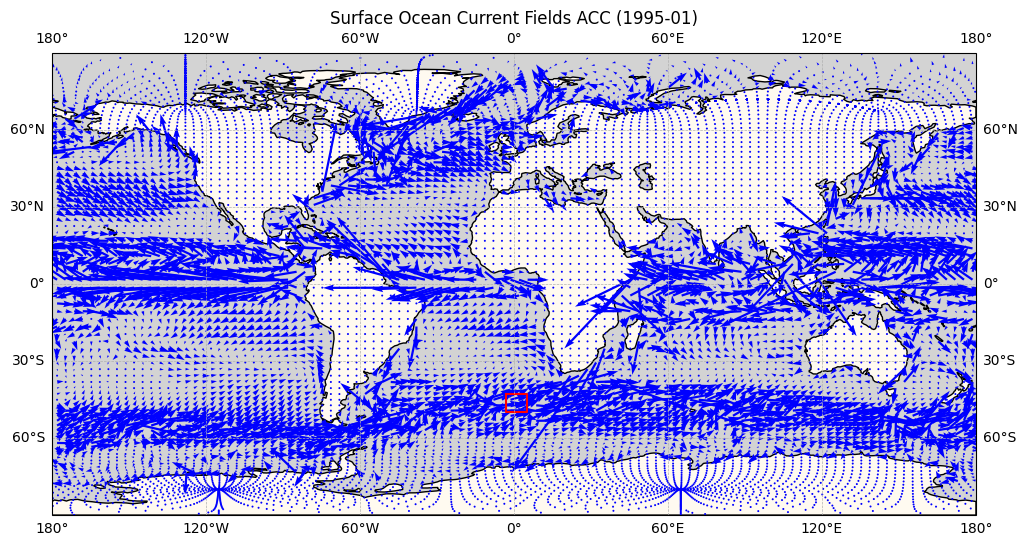

In [5]:
# Load the NetCDF files using Xarray
ds_U = xr.open_dataset(f"{path}\\UVEL_{date}.nc")
ds_V = xr.open_dataset(f"{path}\\VVEL_{date}.nc")

# Select only the surface (level=0) and extract the first time step
U_surface = ds_U["UVEL"].isel(Time=0)
V_surface = ds_V["VVEL"].isel(Time=0)

# Longitude and latitude coordinates
X = ds_U["Longitude"].values
Y = ds_U["Latitude"].values

# Define the extent to zoom into the region of interest
extent = [-3, 5, -43, -50]

%matplotlib inline
# Create the figure with a specified size
plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent(extent)
ax.plot([extent[0], extent[1], extent[1], extent[0], extent[0]], 
        [extent[2], extent[2], extent[3], extent[3], extent[2]], 
        color="red", linestyle='-')

# Add oceanic and terrestrial features
ax.add_feature(cartopy.feature.OCEAN, facecolor="lightgrey")
ax.add_feature(cartopy.feature.LAND, edgecolor="black", facecolor="floralwhite")

# Add grid lines
ax.gridlines(draw_labels=True, linestyle="--", linewidth=0.5)

# Display the velocity field with quiver (vector arrows)
skip = 10  # Arrow spacing to avoid visual overload
ax.quiver(X[::skip, ::skip], Y[::skip, ::skip], U_surface.values[0, ::skip, ::skip], 
          V_surface.values[0, ::skip, ::skip], transform=ccrs.PlateCarree(), color='blue', scale=8)

plt.title(f"Surface Ocean Current Fields ACC ({date})")
plt.show()

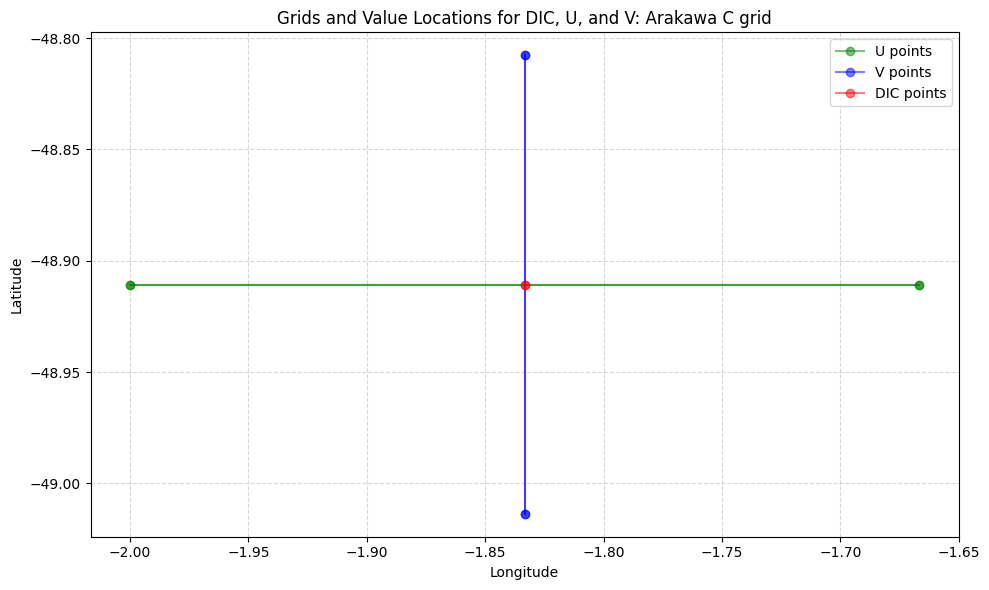

In [6]:
# Retrieve the coordinates
lonDIC, latDIC = fieldset.DIC.grid.lon[312, 648], fieldset.DIC.grid.lat[312, 648]  # DIC grid (concentration, centered)
lonU, latU = fieldset.U.grid.lon[312, 648:650], fieldset.U.grid.lat[312, 648:650]  # UVEL grid (West-East boundary)
lonV, latV = fieldset.V.grid.lon[312:314, 648], fieldset.V.grid.lat[312:314, 648]  # VVEL grid (North-South boundary)

# Create the figure
%matplotlib inline
plt.figure(figsize=(10, 6))

# Plot the grids with lines and points
plt.plot(lonU, latU, 'o-', color='green', alpha=0.5, label='U points')  # UVEL grid
plt.plot(lonU.T, latU.T, 'o-', color='green', alpha=0.5)

plt.plot(lonV, latV, 'o-', color='blue', alpha=0.5, label='V points')  # VVEL grid
plt.plot(lonV.T, latV.T, 'o-', color='blue', alpha=0.5)

plt.plot(lonDIC, latDIC, 'o-', color='red', alpha=0.5, label='DIC points')  # DIC grid (Concentration)
plt.plot(lonDIC.T, latDIC.T, 'o-', color='red',alpha=0.5)

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Grids and Value Locations for DIC, U, and V: Arakawa C grid")

plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.legend()
plt.show()

### 1) b. Load the monthly mean forcing data of rapid-mCDR model at the desired area from ECCO-Darwin dataset

In [7]:
# Load the monthly mean forcing data
data = xr.open_dataset(f"C:\\Users\\ocean\\PycharmProjects\\Master MIX\\StageM2\\ED-OP\\DatasLLC270\\{region}_monthly_mean_forcing_data.nc")

# Select the time of the data
data = data.sel(year_month=date)

# Load the variables from the forcing data
k_surf = data["k_surf"].values # Surface exchange coefficient (mol m / (atm kg s))
siarea = data["siarea"].values # Sea ice fractional ice-covered area (0-1)
area = data["area"].values # Horizontal area of the grid cells in the rapid-mCDR model (m²)
alk_forcing = data["alk_forcing"].values # Alkalinity forcing = add of ALK at the surface (meq/s)
Zl = data["Zl"].values # Depth of the vertical grid cells in the rapid-mCDR model (m)

# Add the variables to the fieldset
fieldset.add_constant("k_surf", k_surf)
fieldset.add_constant("siarea", siarea)
fieldset.add_constant("alk_forcing", alk_forcing / area)

# Add the vertical grid cell thickness at the surface to the fieldset
dz = np.abs(Zl[1:] - Zl[:-1]) # Thickness of the vertical grid cells in the rapid-mCDR model
fieldset.add_constant("dz", dz[0]) # Thickness of the first vertical layer
dz

array([ 10.      ,  10.      ,  10.      ,  10.      ,  10.      ,
        10.      ,  10.      ,  10.010002,  10.029999,  10.110001,
        10.32    ,  10.799995,  11.760002,  13.419998,  16.040009,
        19.819992,  24.850006,  31.09999 ,  38.42    ,  46.5     ,
        55.      ,  63.5     ,  71.58002 ,  78.89996 ,  85.150024,
        90.17999 ,  93.96002 ,  96.58002 ,  98.25    ,  99.25    ,
       100.01001 , 101.329956, 104.56006 , 111.329956, 122.829956,
       139.09009 , 158.93994 , 180.82996 , 203.55005 , 226.5     ,
       249.5     , 272.5     , 295.5     , 318.5     , 341.5     ,
       364.5     , 387.5     , 410.5     , 433.5     ], dtype=float32)

In [8]:
# Load the pCO2 sensitivity data
data = xr.open_dataset(f"C:\\Users\\ocean\\PycharmProjects\\Master MIX\\StageM2\\ED-OP\\DatasLLC270\\sensitivity_pco2_{date}.nc")

# Load the variables from the pCO2 sensitivity for DIC and ALK
dpco2_ddic = data["dpco2_ov_ddic"].values # In atm kg/mol ALK
dpco2_dalk = data["dpco2_ov_dalk"].values # In atm kg/mol C

# Add the variables of pCO2 sensitivity to the fieldset
fieldset.add_constant("dpco2_ddic", dpco2_ddic)
fieldset.add_constant("dpco2_dalk", dpco2_dalk)

## 2) Define Kernels for the continuous OAE simulation with OceanParcels

In [9]:
def RapidmCDRModel(particle, fieldset, time):
    """ 
    Kernel to implement the Rapid-mCDR model for the OAE method in horizontal OceanParcels simulations.
    This kernel calculates the change in the ALK0 and DIC0 fields due to advection of the particle, surface forcing (continuously alkalinity addition) and air-sea sink (CO2 exchange).
    """
    
    ### Define the cell indexes of the particle in the grid and the depth level ###
    z = 0  # First level in depth (surface)
    dt = particle.dt
    dz = fieldset.dz
    _ = fieldset.UV[particle] 
    
    xi, yi = particle.xi[fieldset.V.igrid], particle.yi[fieldset.U.igrid]
    0
    # Correction of indexes if necessary
    if abs(particle.lon - fieldset.V.grid.lon[yi, xi + 1]) < abs(particle.lon - fieldset.V.grid.lon[yi, xi]):
        xi += 1
    if abs(particle.lat - fieldset.U.grid.lat[yi + 1, xi]) < abs(particle.lat - fieldset.U.grid.lat[yi, xi]):
        yi += 1
    if abs(particle.lon - fieldset.V.grid.lon[yi, xi - 1]) < abs(particle.lon - fieldset.V.grid.lon[yi, xi]):
        xi -= 1
    if abs(particle.lat - fieldset.U.grid.lat[yi - 1, xi]) < abs(particle.lat - fieldset.U.grid.lat[yi, xi]):
        yi -= 1
    
    # Get the zero DIC and ALK concentration fields for the OAE simulation
    ALK0 = fieldset.ALK0.data[z]  # In µM ALK
    DIC0 = fieldset.DIC0.data[z]  # In µM C

    # Get the DIC, ALK and f_co2_pot fields for the ECCO-Darwin original simulation
    ALK = fieldset.ALK.data[z]  # In µM ALK 
    DIC = fieldset.DIC.data[z]  # In µM C
    f_co2_pot = fieldset.f_co2_pot.data[z]  # In µM m/s
    
    ### Calculate the change in the ALK0 and DIC0 fields due to particle transport and surface forcings (alkalinity addition/CO2 exchange) ###
    # Compute the surface exchange of CO2 for the OAE simulation
    f_co2_prev = - fieldset.k_surf * (1 - fieldset.siarea) * (fieldset.dpco2_ddic[z, yi, xi] * DIC0[yi, xi] + fieldset.dpco2_dalk[z, yi, xi] * ALK0[yi, xi])
    
    # Update the ALK0 concentration in the fieldset with the addition of ALK to the initial cell surface
    if time < 86400:
        ALK0[yi, xi] += (particle.f_alk / dz) * dt  # In micromole per liter = micro-molar = µM ALK
        ### Add alkalinity forcing = 0.00012409 meq/(m² s) converted to µM ALK in the surface layer of thickness dz over the time step dt ###
        
    # Update the DIC0 concentration in the fieldset with the addition of CO2 exchange at the surface
    DIC0[yi, xi] += (f_co2_prev / dz) * dt  # In micromole per liter = micro-molar = µM C
    
    # Update the ALK0 and DIC0 concentration fields in the fieldset due to the particle movement
    if xi != particle.cell_x or yi != particle.cell_y:
        ALK0[yi, xi] += ALK0[particle.cell_y, particle.cell_x]
        ALK0[particle.cell_y, particle.cell_x] = 0
        DIC0[yi, xi] += DIC0[particle.cell_y, particle.cell_x]
        DIC0[particle.cell_y, particle.cell_x] = 0
    
    ### Calculate the final change in the surface exchange of CO2 and update the f_co2 variable and f_co2_pot field ###
    # Compute the final surface exchange of CO2 for the OAE simulation
    particle.f_co2 = - fieldset.k_surf * (1 - fieldset.siarea) * (fieldset.dpco2_ddic[z, yi, xi] * DIC0[yi, xi] + fieldset.dpco2_dalk[z, yi, xi] * ALK0[yi, xi])
    
    # Compute the surface exchange of CO2 for the original simulation from ECCO-Darwin data
    f_co2_pot[yi, xi] = - fieldset.k_surf * (1 - fieldset.siarea) * (fieldset.dpco2_ddic[z, yi, xi] * DIC[yi, xi] + fieldset.dpco2_dalk[z, yi, xi] * ALK[yi, xi])
        
    # Save the particle's position for the next loop
    particle.cell_x = xi
    particle.cell_y = yi

    # Update the concentration field time to ensure temporal consistency
    fieldset.ALK0.grid.time[0] = time
    fieldset.DIC0.grid.time[0] = time

In [10]:
def AdvectionParticle(particle, fieldset, time):
    """
    Kernel to advect the particle using the 4th order Runge-Kutta method.
    This method is used to calculate the new position of the particle based on the velocity field.
    """
    particle.lon = particle.lon_nextloop
    particle.lat = particle.lat_nextloop
    
    (u1, v1) = fieldset.UV[time, particle.depth, particle.lat, particle.lon]
    # (u1, v1) = fieldset.UV[particle]
    lon1_adv, lat1_adv = (particle.lon + u1*.5*particle.dt, particle.lat + v1*.5*particle.dt)
    
    (u2, v2) = fieldset.UV[time + .5 * particle.dt, particle.depth, lat1_adv, lon1_adv]
    lon2_adv, lat2_adv = (particle.lon + u2*.5*particle.dt, particle.lat + v2*.5*particle.dt)
    
    (u3, v3) = fieldset.UV[time + .5 * particle.dt, particle.depth, lat2_adv, lon2_adv]
    lon3_adv, lat3_adv = (particle.lon + u3*particle.dt, particle.lat + v3*particle.dt)
    
    (u4, v4) = fieldset.UV[time + particle.dt, particle.depth, lat3_adv, lon3_adv]
    
    particle_dlon = (u1 + 2*u2 + 2*u3 + u4) / 6. * particle.dt
    particle_dlat = (v1 + 2*v2 + 2*v3 + v4) / 6. * particle.dt 
    
    particle.lon_nextloop = particle.lon + particle_dlon
    particle.lat_nextloop = particle.lat + particle_dlat 

## 3) Run the OceanParcels simulation with the Rapid-mCDR model to simulate the continuous OAE method 

### 3) a. Select the particle to track and the Kernel (Transport + OAE Method)

In [11]:
### Select the Particle to track and the Kernel (Transport + Conservation Methods) ###
position = (-2, -49)  # Initial position of the particle (longitude, latitude)
last_time = 31  # Number of days to run the simulation

In [12]:
# Definition of the particle and variables to track
class Particle(parcels.ScipyParticle):
    forcing_alk = parcels.Variable('f_alk', dtype=np.float64, initial=fieldset.alk_forcing) # Additional alkalinity forcing (in meq/(m² s))
    fluxes_co2 = parcels.Variable('f_co2', dtype=np.float64, initial=0.0)  # Surface exchange of CO2 (in µM m/s)
    endtime = parcels.Variable('endtime', dtype=np.int64, initial=last_time * 86400)  # End time of the particle tracking (in seconds)
    cell_x = parcels.Variable('cell_x', dtype=np.int32, initial=-1)  # Index of particle position at previous step in the grid (longitude)
    cell_y = parcels.Variable('cell_y', dtype=np.int32, initial=-1)  # Index of particle position at previous step in the grid (latitude)
    
lon_nextloop = Particle.add_variable('lon_nextloop', dtype=np.float32, to_write=True)  # Longitude of the particle at the next loop
lat_nextloop = Particle.add_variable('lat_nextloop', dtype=np.float32, to_write=True)  # Latitude of the particle at the next loop

# Creation of a particle set
pset = parcels.ParticleSet(fieldset=fieldset, pclass=Particle, lon=[position[0]], lat=[position[1]])

### 3) b. Run the simulation during 1 month with 1 addition of ALK flux every day to the surface of the initial cell

In [13]:
# Define the folder name to save the results
filename_save = f"DailyRapidmCDR_LLC270_ACC_{date}_{depth}"

# Execution of the simulation
output_file = pset.ParticleFile(name=f"{filename_save}.zarr", outputdt=timedelta(days=1))

# Execute the simulation with the defined kernels and time step
kernels = pset.Kernel(RapidmCDRModel) + pset.Kernel(AdvectionParticle)
pset.execute(kernels, 
             dt=timedelta(days=1), 
             runtime=timedelta(days=last_time), 
             output_file=output_file
             )
    
# Loop for 31 days to progressively add particles every day at the same localisation (daily/continuously OAE) and track them for a decreasing number of days
for day in range(1, last_time):
    print(f"Day {day}: injecting a new particle at the initial position {position} and tracking it for {last_time - day} days")

    # Create a new ParticleSet with a single particle
    new_particle = parcels.ParticleSet(
        fieldset=fieldset,
        pclass=Particle,
        lon=[position[0]],
        lat=[position[1]]
    )

    # Set the end time for the new particle
    for p in new_particle:
        p.endtime = (last_time - day) * 86400

    # Add the new particle to the existing particle set
    pset.add(new_particle)

    # Determine the remaining runtime for the newly added particle
    remaining_runtime = timedelta(days=last_time - day)

    # Execute the simulation for the given day (evolving particles for 1 day at a time)
    pset.execute(
        pset.Kernel(RapidmCDRModel) 
        + pset.Kernel(AdvectionParticle),  # Add the kernels for the rapid-mCDR model
        dt=timedelta(days=1),
        runtime=remaining_runtime,  
        output_file=output_file,
    )

INFO: Output files are stored in DailyRapidmCDR_LLC270_ACC_1995-01_0.zarr.
100%|██████████| 2678400.0/2678400.0 [00:28<00:00, 92786.96it/s] 
Day 1: injecting a new particle at the initial position (-2, -49) and tracking it for 30 days
INFO: Output files are stored in DailyRapidmCDR_LLC270_ACC_1995-01_0.zarr.
100%|██████████| 2592000.0/2592000.0 [00:05<00:00, 484153.25it/s]
Day 2: injecting a new particle at the initial position (-2, -49) and tracking it for 29 days
INFO: Output files are stored in DailyRapidmCDR_LLC270_ACC_1995-01_0.zarr.
100%|██████████| 2505600.0/2505600.0 [00:05<00:00, 479866.48it/s]
Day 3: injecting a new particle at the initial position (-2, -49) and tracking it for 28 days
INFO: Output files are stored in DailyRapidmCDR_LLC270_ACC_1995-01_0.zarr.
100%|██████████| 2419200.0/2419200.0 [00:34<00:00, 70589.42it/s] 
Day 4: injecting a new particle at the initial position (-2, -49) and tracking it for 27 days
INFO: Output files are stored in DailyRapidmCDR_LLC270_ACC_1

## 4) Load and visualize the results of the continuous OAE simulation

In [15]:
# Define the folder name to load the results
filename = f"DailyRapidmCDR_LLC270_ACC_{date}_{depth}"

# Load the results
pset_traj = xr.open_zarr(f"{filename}.zarr")

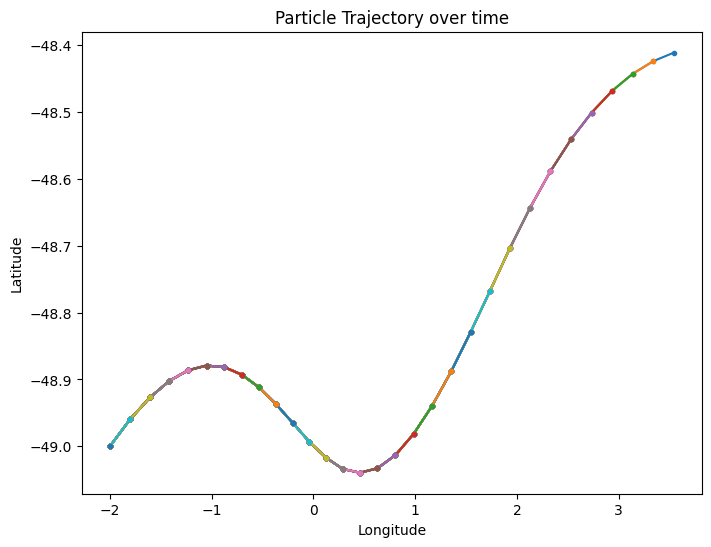

In [16]:
%matplotlib inline
# Plot the particle trajectories
plt.figure(figsize=(8, 6))
plt.plot(pset_traj["lon"].T, pset_traj["lat"].T, ".-")
plt.title("Particle Trajectory over time")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

### Plot the concentration fields of ALK and DIC at the beginning and the end of the continuous OAE simulation with addition of ALK flux every day at the initial cell

In [17]:
# Define the extent to zoom in on the area of interest
extent = [-3, 5, -50, -48]

# Define the coordinates for the grid
lon = fieldset.V.grid.lon
sample_x = fieldset.U.grid.lon[lon.shape[0]*3//4, :][(fieldset.U.grid.lon[lon.shape[0]*3//4, :] >= extent[0]) & (fieldset.U.grid.lon[lon.shape[0]*3//4, :] <= extent[1])][::2]
sample_y = fieldset.V.grid.lat[:, lon.shape[1]//2][(fieldset.V.grid.lat[:, lon.shape[1]//2] >= extent[2]) & (fieldset.V.grid.lat[:, lon.shape[1]//2] <= extent[3])][::2]

In [18]:
print(f"Concentration of alk forcing particle added to initial cell over time (meq/(m²s)) : \n {pset_traj['f_alk'].values[0]}")

Concentration of alk forcing particle added to initial cell over time (meq/(m²s)) : 
 [0.00012409 0.00012409 0.00012409 0.00012409 0.00012409 0.00012409
 0.00012409 0.00012409 0.00012409 0.00012409 0.00012409 0.00012409
 0.00012409 0.00012409 0.00012409 0.00012409 0.00012409 0.00012409
 0.00012409 0.00012409 0.00012409 0.00012409 0.00012409 0.00012409
 0.00012409 0.00012409 0.00012409 0.00012409 0.00012409 0.00012409
 0.00012409]


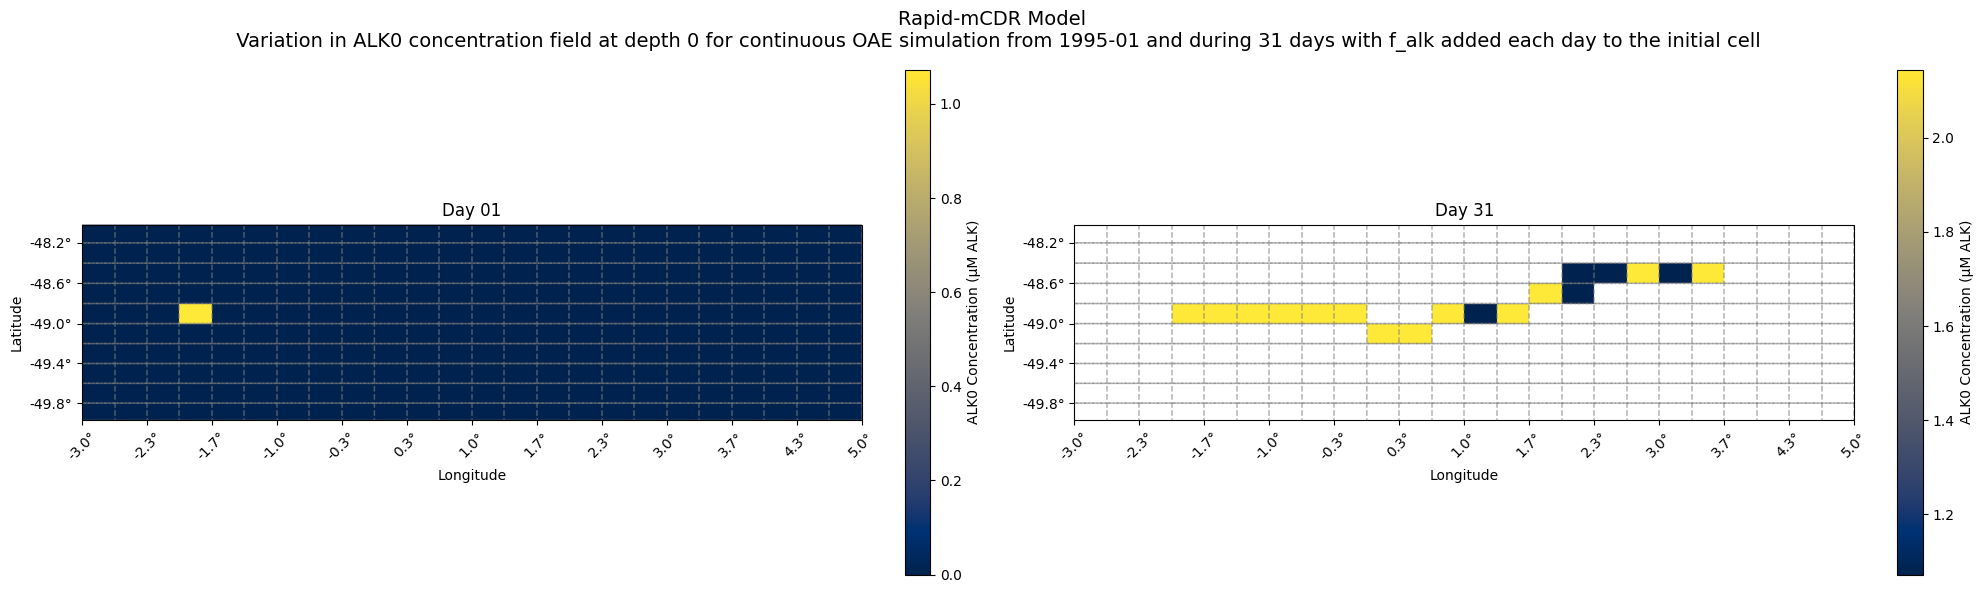

In [19]:
# Define the variable to display
var_name = "ALK0"
particle_name = "f_alk"

# Select the days to display
dayFirst = "0001"
dayLast = "0496"

# Load the NetCDF files for each specified days
first = xr.open_dataset(f"{filename}_{dayFirst}{var_name}.nc")
last = xr.open_dataset(f"{filename}_{dayLast}{var_name}.nc")

# Extract the concentration fields for the specified days
fieldF = first[f"{var_name}"].values[0, 0, :, :]  # Level 0 in depth, first time step (date)
fieldL = last[f"{var_name}"].values[0, 0, :, :]

# Masking values of the field where the value is equal to the initial concentration field:
# Areas that have not been modified by the particle, for clearer visualization
fieldL[fieldL == fieldF] = np.nan

# Extract longitude and latitude coordinates
longitudes = first["nav_lon"].values
latitudes = first["nav_lat"].values

%matplotlib inline
fig, axes = plt.subplots(ncols=2, figsize=(20, 6), subplot_kw={'projection': ccrs.PlateCarree()})
fig.suptitle(f"Rapid-mCDR Model \n Variation in {var_name} concentration field at depth {depth} for continuous OAE simulation from {date} and during {last_time} days with {particle_name} added each day to the initial cell", fontsize=14)

end_simu = int(dayLast)%last_time
for ax, fieldDIC, title in zip(axes, [fieldF, fieldL], [f"Day {dayFirst[-2:]}", f"Day {[end_simu + 31 if end_simu == 0 else end_simu][0]}"]):
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.LAND, edgecolor="black", facecolor="floralwhite")
    ax.set_title(f"{title}")

    # Display the concentration data
    results = ax.pcolormesh(longitudes, latitudes, fieldDIC, transform=ccrs.PlateCarree(), cmap="cividis")
    
    # Add a colorbar for each concentration field
    cbar = fig.colorbar(results, ax=ax, orientation="vertical", fraction=0.05)
    cbar.set_label(f"{var_name} Concentration (µM ALK)")

    # Add gridlines and labels
    ax.set_xticks(sample_x, crs=ccrs.PlateCarree())
    ax.set_yticks(sample_y, crs=ccrs.PlateCarree())
    ax.set_xticklabels([f"{lon:.1f}°" for lon in sample_x], rotation=45)
    ax.set_yticklabels([f"{lat:.1f}°" for lat in sample_y])
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    for i in range(lon.shape[0]):
        ax.plot(fieldset.V.grid.lon[i, :], fieldset.V.grid.lat[i, :], color='gray', linewidth=1.1, linestyle='--', transform=ccrs.PlateCarree(), alpha=0.6)
    for j in range(lon.shape[1]):
        ax.plot(fieldset.U.grid.lon[:, j], fieldset.U.grid.lat[:, j], color='gray', linewidth=1.1, linestyle='--', transform=ccrs.PlateCarree(), alpha=0.6)

# # Display particles as scatter points on the first plot
# particle = axes[0].scatter(
#     pset_traj["lon"].values[0], pset_traj["lat"].values[0], c=pset_traj[f"{particle_name}"].values[0], transform=ccrs.PlateCarree(),
#     s=100, edgecolor="white", cmap="gist_earth"
# )
# 
# # Add a colorbar for particle concentration
# particle_cbar = plt.colorbar(particle, ax=axes[0], orientation="horizontal")
# particle_cbar.set_label(f"Transport of alkalinity {particle_name} added to initial cell over time in zero alkalinity field (meq/(m² s))", fontsize=12)

plt.tight_layout()
plt.show()

In [20]:
print(f"At the end of the simulation, the total ALK0 field is {np.nansum(fieldL)} µM ALK. This value must match the total ALK flux added each day to the initial cell, after conversion to µM ALK: {np.nansum(pset_traj['f_alk'].values[:, 0] * timedelta(days=1).total_seconds() / dz[0])}")

At the end of the simulation, the total ALK0 field is 33.23534471191011 µM ALK. This value must match the total ALK flux added each day to the initial cell, after conversion to µM ALK: 33.235344711910116


In [21]:
print(f"Total concentration of particles representing air-sea CO2 fluxes at the surface at the end of the continuous OAE simulation: \n {np.nansum(pset_traj['f_co2'].values, axis=0)}")

Total concentration of particles representing air-sea CO2 fluxes at the surface at the end of the continuous OAE simulation: 
 [2.26941855e-04 1.98516867e-04 1.97388882e-04 1.71959848e-04
 1.70906611e-04 1.48189085e-04 1.47213694e-04 1.26947282e-04
 1.26054572e-04 1.08000836e-04 1.07205640e-04 9.11442987e-05
 9.06482691e-05 7.63378357e-05 7.57228657e-05 6.30304952e-05
 6.24538532e-05 5.12222381e-05 4.76241360e-05 4.72125367e-05
 3.75130977e-05 3.70327244e-05 2.85068627e-05 2.53938769e-05
 2.21548048e-05 1.90226101e-05 1.86172002e-05 1.17991389e-05
 8.85087076e-06 8.44440645e-06 2.73995875e-06]


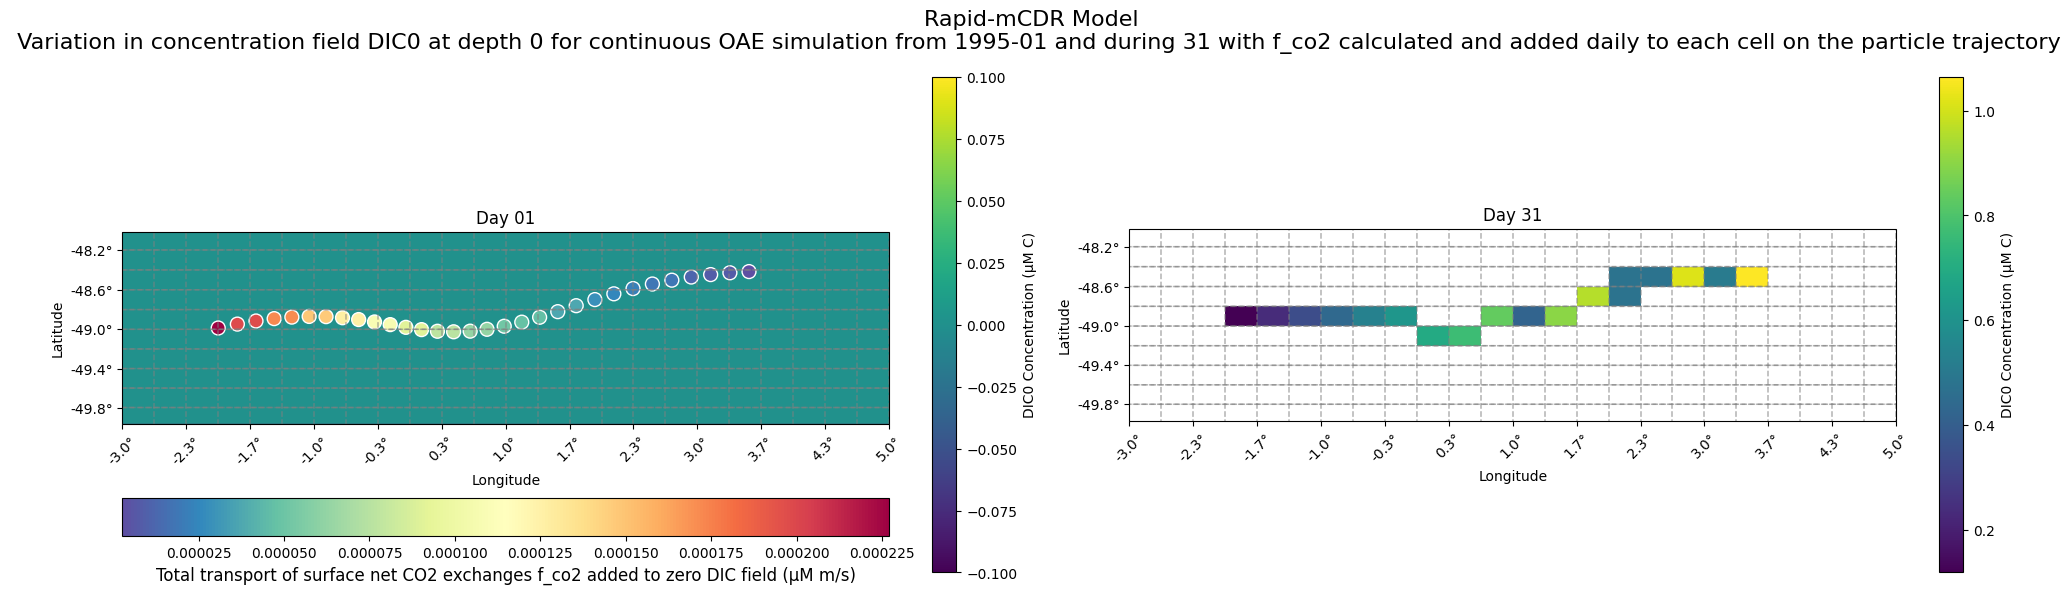

In [22]:
# Define the variable to display
var_name = "DIC0"
flux_name = "f_co2"

# Select the days to display
dayFirst = "0001"
dayLast = "0496"

# Load the NetCDF files for each specified days
first = xr.open_dataset(f"{filename}_{dayFirst}{var_name}.nc")
last = xr.open_dataset(f"{filename}_{dayLast}{var_name}.nc")

# Extract the concentration fields for the specified days
fieldF = first[f"{var_name}"].values[0, 0, :, :]  # Level 0 in depth, first time step (date)
fieldL = last[f"{var_name}"].values[0, 0, :, :]

# Masking values of the field where the value is equal to the initial concentration field:
# Areas that have not been modified by the particle, for clearer visualization
fieldL[fieldL == fieldF] = np.nan

# Extract longitude and latitude coordinates
longitudes = first["nav_lon"].values
latitudes = first["nav_lat"].values


%matplotlib inline
fig, axes = plt.subplots(ncols=2, figsize=(20, 6), subplot_kw={'projection': ccrs.PlateCarree()})
fig.suptitle(f"Rapid-mCDR Model \n Variation in concentration field {var_name} at depth {depth} for continuous OAE simulation from {date} and during {last_time} with {flux_name} calculated and added daily to each cell on the particle trajectory", fontsize=16)

end_simu = int(dayLast)%last_time
for ax, fieldDIC, title in zip(axes, [fieldF, fieldL], [f"Day {dayFirst[-2:]}", f"Day {[end_simu + 31 if end_simu == 0 else end_simu][0]}"]):
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.LAND, edgecolor="black", facecolor="floralwhite")
    ax.set_title(f"{title}")

    # Display the concentration data
    results = ax.pcolormesh(longitudes, latitudes, fieldDIC, transform=ccrs.PlateCarree(), cmap="viridis")
    
    # Add a colorbar for each concentration field
    cbar = fig.colorbar(results, ax=ax, orientation="vertical", fraction=0.05)
    cbar.set_label(f"{var_name} Concentration (µM C)")
    
    # Add gridlines and labels
    ax.set_xticks(sample_x, crs=ccrs.PlateCarree())
    ax.set_yticks(sample_y, crs=ccrs.PlateCarree())
    ax.set_xticklabels([f"{lon:.1f}°" for lon in sample_x], rotation=45)
    ax.set_yticklabels([f"{lat:.1f}°" for lat in sample_y])
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    for i in range(lon.shape[0]):
        ax.plot(fieldset.V.grid.lon[i, :], fieldset.V.grid.lat[i, :], color='gray', linewidth=1.1, linestyle='--', transform=ccrs.PlateCarree(), alpha=0.6)
    for j in range(lon.shape[1]):
        ax.plot(fieldset.U.grid.lon[:, j], fieldset.U.grid.lat[:, j], color='gray', linewidth=1.1, linestyle='--', transform=ccrs.PlateCarree(), alpha=0.6)

# Display particles as scatter points on the first plot
particle = axes[0].scatter(
    pset_traj["lon"].values[0], pset_traj["lat"].values[0], c=np.nansum(pset_traj['f_co2'].values, axis=0), transform=ccrs.PlateCarree(),
    s=100, edgecolor="white", cmap="Spectral_r"
)

# Add a colorbar for particle concentration
particle_cbar = plt.colorbar(particle, ax=axes[0], orientation="horizontal")
particle_cbar.set_label(f"Total transport of surface net CO2 exchanges {flux_name} added to zero DIC field (µM m/s)", fontsize=12)

plt.tight_layout()
plt.show()

## 5) Plot the DIC and ALK fields from ECCO-Darwin outputs with the surface exchange of CO2 calculated without OAE method along the particle trajectory 

In [23]:
f_co2_pot = np.where(fieldset.f_co2_pot.data[0] != 0, fieldset.f_co2_pot.data[0], np.nan)  # Mask the values of f_co2_pot where the value is equal to 0
print(f"Total concentration of particles representing CO2 exchanges at the surface at the end of the original simulation (without OAE method): {f_co2_pot[~np.isnan(f_co2_pot)]}")

Total concentration of particles representing CO2 exchanges at the surface at the end of the original simulation (without OAE method): [-0.00222157 -0.00221974 -0.00223893 -0.0022357  -0.00223177 -0.00222723
 -0.00222241 -0.00221805 -0.00221678 -0.00221995 -0.00222482 -0.00222314
 -0.00222854 -0.00222056 -0.00222478 -0.00222849 -0.0022288  -0.00222803]


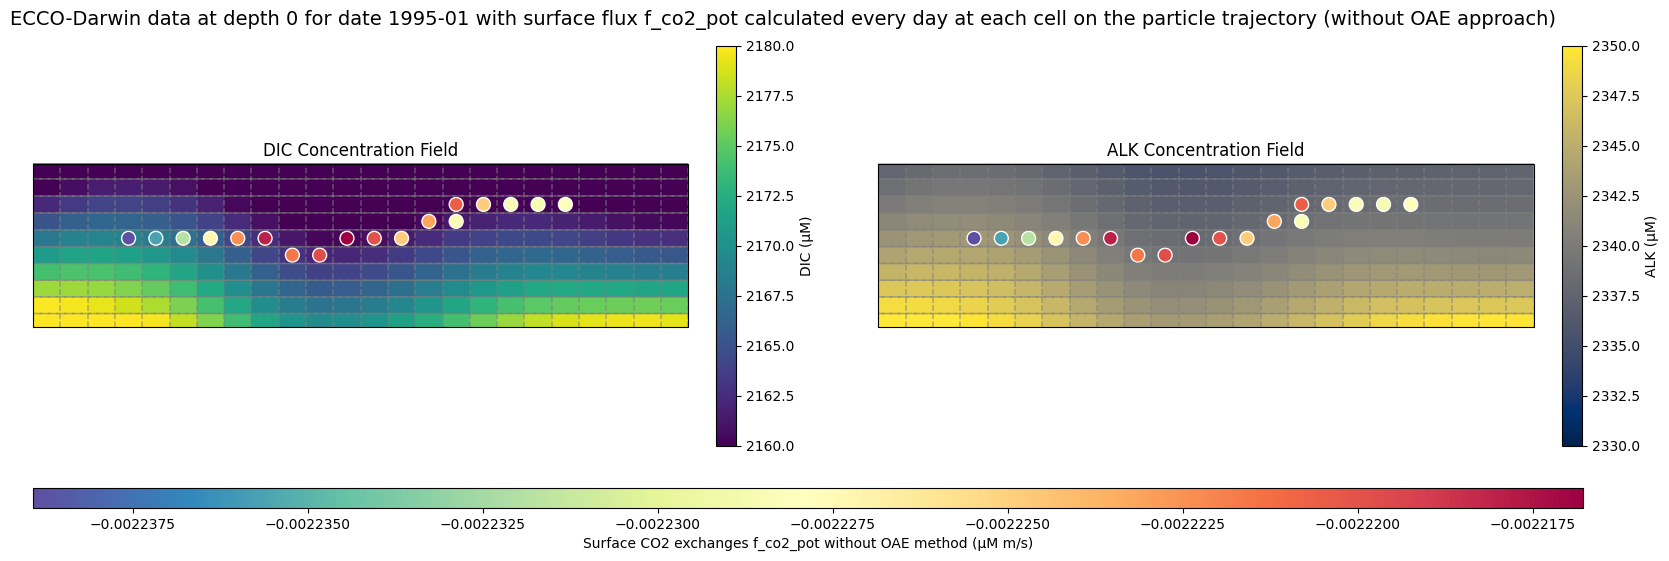

In [25]:
# Plotting parameters
extent = [-3, 5, -50, -48]
var_names = ["DIC", "ALK"]
flux_name = "f_co2_pot"
fields = [fieldset.DIC.data[0], fieldset.ALK.data[0]]  # µMol C and µMol ALK
cmaps = ["viridis", "cividis"]
vmins = [2160, 2330]
vmaxs = [2180, 2350]

# Grid coordinates
longitudes = fieldset.DIC.grid.lon
latitudes = fieldset.DIC.grid.lat

# Mask to remove NaN values from f_co2_pot
valid_mask = ~np.isnan(f_co2_pot)
lon_mask = longitudes[valid_mask]
lat_mask = latitudes[valid_mask]
f_co2_pot_mask = f_co2_pot[valid_mask]

# Create figure
fig = plt.figure(figsize=(20, 6))
gs = gridspec.GridSpec(2, 2, height_ratios=[20, 1])  
fig.suptitle(f"ECCO-Darwin data at depth {depth} for date {date} with surface flux {flux_name} calculated every day at each cell on the particle trajectory (without OAE approach)", fontsize=14, y=0.94)

# Create the two map plots
for i in range(2):
    ax = fig.add_subplot(gs[0, i], projection=ccrs.PlateCarree())
    ax.set_extent(extent, crs=ccrs.PlateCarree())  # Set the map extent
    ax.add_feature(cfeature.LAND, edgecolor="black", facecolor="floralwhite")  # Add land features
    
    # Display the concentration field
    mesh = ax.pcolormesh(longitudes, latitudes, fields[i], transform=ccrs.PlateCarree(), cmap=cmaps[i], vmin=vmins[i], vmax=vmaxs[i])
    
    # Add velocity gridlines (U and V grid)
    for x in range(fieldset.V.grid.lon.shape[0]):
        ax.plot(fieldset.V.grid.lon[x, :], fieldset.V.grid.lat[x, :], color='gray', linewidth=1.1, linestyle='--', transform=ccrs.PlateCarree(), alpha=0.6)
    for y in range(fieldset.U.grid.lon.shape[1]):
        ax.plot(fieldset.U.grid.lon[:, y], fieldset.U.grid.lat[:, y], color='gray', linewidth=1.1, linestyle='--', transform=ccrs.PlateCarree(), alpha=0.6)
    
    # Add f_co2_pot values as scatter points
    cbar = ax.scatter(lon_mask, lat_mask, c=f_co2_pot_mask, transform=ccrs.PlateCarree(), s=100, edgecolor="white", cmap="Spectral_r")
    
    ax.set_title(f"{var_names[i]} Concentration Field")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")

    # Colorbar for the background field (DIC or ALK)
    cbar_main = fig.colorbar(mesh, ax=ax, orientation="vertical", fraction=0.03, pad=0.04)
    cbar_main.set_label(f"{var_names[i]} (µM)")

# Colorbar for the particle flux 
cax = fig.add_subplot(gs[1, :])
cbar_particles = fig.colorbar(cbar, cax=cax, orientation="horizontal")
cbar_particles.set_label(f"Surface CO2 exchanges {flux_name} without OAE method (µM m/s)")

plt.show()